In [156]:
import yfinance as yt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [157]:
# download data
ticker = "AMZN"
df = yt.download(ticker, start = "2012-01-01")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,8.7945,8.9740,8.7775,8.9515,8.9515,102216000
2012-01-04,8.9605,9.0250,8.8035,8.8755,8.8755,84104000
2012-01-05,8.7970,8.9125,8.7025,8.8805,8.8805,76182000
2012-01-06,8.9035,9.2325,8.8750,9.1305,9.1305,140168000
2012-01-09,9.1380,9.2185,8.8500,8.9280,8.9280,101138000


Text(0, 0.5, 'Close price')

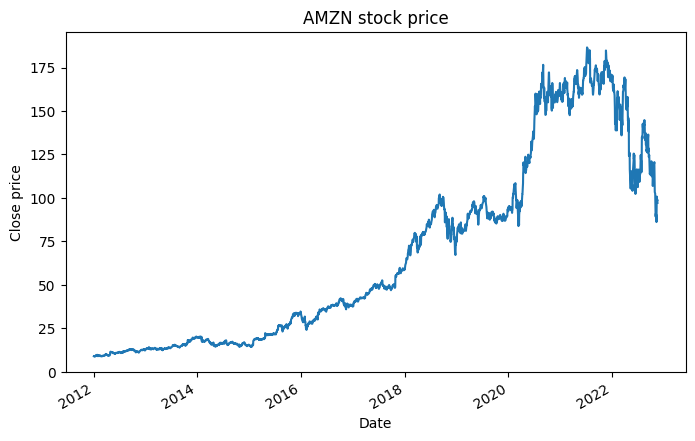

In [158]:
# plot data
fig = plt.figure()
ax = fig.add_subplot(111)
df["Close"].plot(figsize = (8, 5))
plt.title("{} stock price".format(ticker))
plt.ylabel("Close price")

In [159]:
# simple strat based on open and close each day
for i, row in df.iterrows():
    if(row["Open"] - row["Close"] < 0):
        df.at[i, "simple_strat_position"] = 1
    else:
        df.at[i, "simple_strat_position"] = -1

In [160]:
# implement simple strat
df["daily_change"] = df["Close"] - df["Open"] # change in value over the day
df["profit_simple_strat"] = df.simple_strat_position.shift(1) * df.daily_change # profit on one day is change in value of that day multiplied by our position
df["return_simple_strat"] = df["profit_simple_strat"].cumsum() # total returns of strategy
df["return_holding_stock"] = [(i-df.iloc[0]["Open"]) for i in df.Open] # return from buying and holding

Text(0, 0.5, 'Returns')

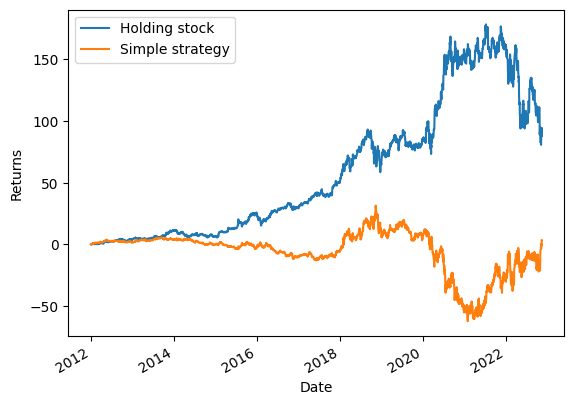

In [161]:
# plot our strat vs holding
df.plot(y = ["return_holding_stock", "return_simple_strat"], label = ["Holding stock", "Simple strategy"])
plt.ylabel("Returns")

# Bolligner band strategy

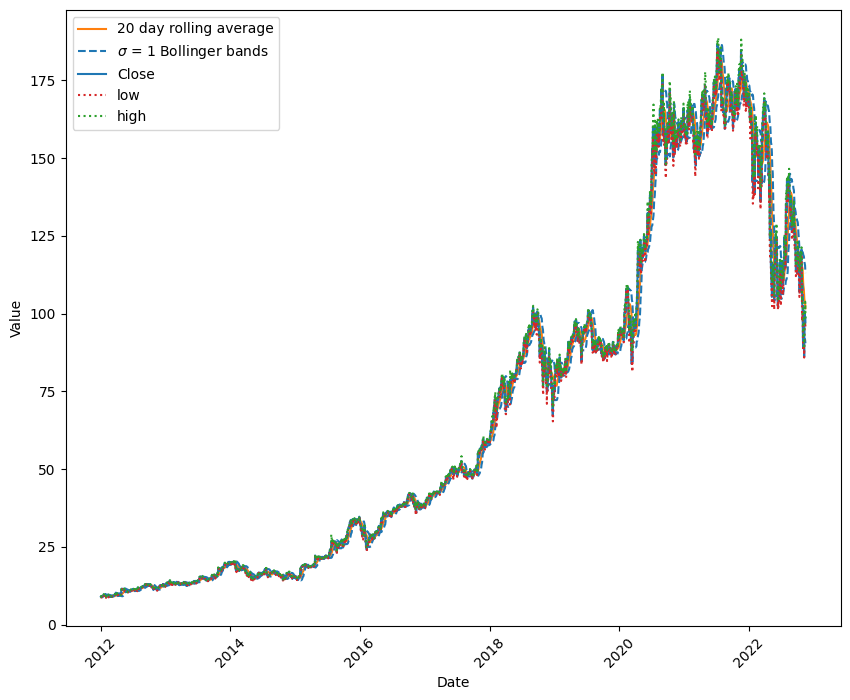

In [162]:
# Calculate Bollinger bands with N = 20 and K = 2
N = 20
K = 1
df["rolling_mean"] = df["Close"].rolling(window=N).mean()
df["rolling_std"] = df["Close"].rolling(window=N).std()
df["lower_bollinger"] = df.rolling_mean - K * df.rolling_std
df["upper_bollinger"] = df.rolling_mean + K * df.rolling_std

# plot graph
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
blue = '#1f77b4'
orange = '#ff7f0e'
red = '#d62728'
green = '#2ca02c'
ax.plot(df.rolling_mean.index, df.rolling_mean, label = "{} day rolling average".format(N), color = orange)
ax.plot(df.lower_bollinger.index, df.lower_bollinger, linestyle = "--", color = blue, label = r"$\sigma$ = {} Bollinger bands".format(K))
ax.plot(df.upper_bollinger.index, df.upper_bollinger, linestyle = "--", color = blue)
ax.plot(df.index, df["Close"], label = "Close", color = blue)
ax.plot(df.index, df["Low"], linestyle = ":", color = red, label = "low")
ax.plot(df.index, df["High"], linestyle = ":", color = green, label = 'high')
ax.set_ylabel("Value")
ax.set_xlabel("Date")
ax.legend()
plt.xticks(rotation = 45)
plt.show()


## Initial attempt
This strategy buys and sells stocks at the end of the day

In [163]:
# create strategy based off bolinger bands
counter = 0
long_pos = False
short_pos = False
long_price = 0
short_price = 0
total_long_positions = 0
total_short_positions = 0
r = 0.1
for i, row in df.iterrows():

    # do nothing for the first 20 days
    if counter < N:
        df.at[i, "profit_bollinger_strat_V1"] = 0
    else:

        # if low falls below lower band
        if(df.at[i, "Low"] < df.at[i, "lower_bollinger"]):

            low = df.at[i, "Low"]
            close = df.at[i, "Close"]

            # if we have a short pos and we can profit, close it
            if short_pos and short_price > low:
                short_pos = False
                total_short_positions -= 1
                df.at[i, "profit_bollinger_strat_V1"] = short_price - close
            else:
                df.at[i, "profit_bollinger_strat_V1"] = 0

            # if we don't have a long position, open one
            if not long_pos:
                long_pos = True
                long_price = close
                total_long_positions += 1
                long_date = i

        # if high goes above upper band
        elif(df.at[i, "High"] > df.at[i, "upper_bollinger"]):

            high = df.at[i, "High"]
            close = df.at[i, "Close"]

            # if we have a long pos and we can profit, close it
            if long_pos and high > long_price:
                long_pos = False
                total_long_positions -= 1
                df.at[i, "profit_bollinger_strat_V1"] = close - long_price
            else:
                df.at[i, "profit_bollinger_strat_V1"] = 0

            # open short pos
            if not short_pos:
                short_pos = True
                short_price = close
                total_short_positions += 1
                short_date = i

        # if high price falls 10% below long, close position and take loss
        elif(df.at[i, "High"] < (1-r)*long_price and long_pos):
            df.at[i, "profit_bolligner_strat_V1"] = df.at[i, "Close"] - long_price
            long_pos = False
            total_long_positions -= 1

        # if low price rises 10% above short, close position and take loss
        elif(df.at[i, "Low"] > (1+r)*short_price and short_pos):
            df.at[i, "profit_bolligner_strat_V1"] = short_price - df.at[i, "Close"]
            short_pos = False
            total_short_positions -= 1

        # if between bands
        else:
            df.at[i, "profit_bollinger_strat_V1"] = 0

    counter += 1

# find cummulative returns
df["return_bollinger_strat_V1"] = df["profit_bollinger_strat_V1"].cumsum()

# check for open and close positions
if total_long_positions > 0:
    print("Warning: {} open long position(s)".format(total_long_positions))
    print(short_date)
if total_short_positions > 0:
    print("Warning: {} open short position(s)".format(total_short_positions))
    print(long_date)


Text(0, 0.5, 'Returns')

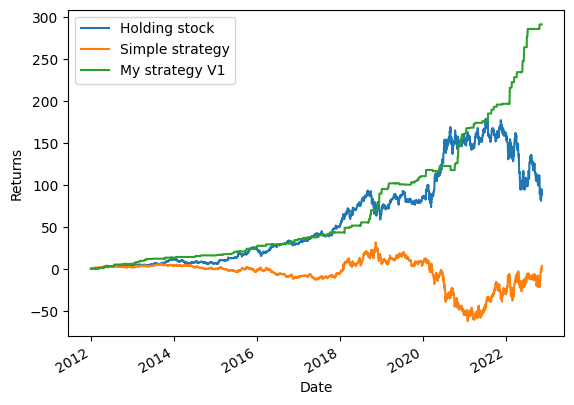

In [164]:
df.plot(y = ["return_holding_stock", "return_simple_strat", "return_bollinger_strat_V1"], 
        label = ["Holding stock", "Simple strategy", "My strategy V1"])
plt.ylabel("Returns")

# Secondary Strategy

The above bolligner strategy assumed that we knew the high and low for each day at the precise moment it happened. This is unrealistic so below we implement a better strategy. We use the high and the low of the previous day to trigger signal, the next day we then trade based off of those signal.

In [165]:
# create strategy based off bolinger bands
counter = 0
long_pos = False
short_pos = False
long_price = 0
short_price = 0
total_long_positions = 0
total_short_positions = 0
trades_made = 0
r = 0.1
profit = 0
for i, row in df.iterrows():

    # do nothing for the first 20 days
    if counter < N:
        df.at[i, "bolligner_long_signal"] = 0
        df.at[i, "bolligner_short_signal"] = 0
    else:

        df.at[i, "bolligner_long_signal"] += 0
        df.at[i, "bolligner_short_signal"] += 0

        # if low falls below lower band
        if(df.at[i, "Close"] < df.at[i, "lower_bollinger"]):

            low = df.at[i, "Low"]
            close = df.at[i, "Close"]

            # if we have a short pos and we can profit, close it
            if short_pos and short_price > close:
                short_pos = False
                total_short_positions -= 1
                df.at[i, "bolligner_short_signal"] = -1
                trades_made += 1
                profit += short_price - close

            # if we don't have a long position, open one
            if not long_pos:
                df.at[i, "bolligner_long_signal"] = 1
                long_pos = True
                long_price = close
                total_long_positions += 1
                long_date = i
                trades_made += 1

        # if close goes above upper band
        elif(df.at[i, "Close"] > df.at[i, "upper_bollinger"]):

            high = df.at[i, "High"]
            close = df.at[i, "Close"]

            # if we have a long pos and we can profit, close it
            if long_pos and close > long_price:
                long_pos = False
                total_long_positions -= 1
                df.at[i, "bolligner_long_signal"] = -1
                trades_made += 1
                profit += close - long_price

            # open short pos
            if not short_pos:
                df.at[i, "bolligner_short_signal"] = 1
                short_pos = True
                short_price = close
                total_short_positions += 1
                short_date = i
                trades_made += 1

        # if price falls 10% below long, close position and take loss
        if(df.at[i, "High"] < (1-r)*long_price and long_pos):
            df.at[i, "bolligner_long_signal"] = -1
            long_pos = False
            total_long_positions -= 1
            trades_made += 1
            profit += df.at[i, "Close"] - long_price

        # if price rises 10% above short, close position and take loss
        elif(df.at[i, "Low"] > (1+r)*short_price and short_pos):
            df.at[i, "bolligner_short_signal"] = -1
            short_pos = False
            total_short_positions -= 1
            trades_made += 1
            profit += short_price - df.at[i, "Close"]

    counter += 1

# check for open and close positions
if total_long_positions > 0:
    print("Warning: {} open long position(s)".format(total_long_positions))
    print(short_date)
if total_short_positions > 0:
    print("Warning: {} open short position(s)".format(total_short_positions))
    print(long_date)

print("Total trades made = {}".format(trades_made))

2022-10-21 00:00:00
Total trades made = 287


In [166]:
# shirt signal by one day
df.bolligner_short_signal.shift(1)
df.bolligner_long_signal.shift(1)

count = 0

# calculate returns
for i, row in df.iterrows():

    # assume nothing happens that day
    df.at[i, "profit_bolligner_strat_V2"] = 0

    # if opening long pos
    if df.at[i, "bolligner_long_signal"] == 1:
        long_price = df.at[i, "Open"]
        count += 1
    # closing long pos
    elif df.at[i, "bolligner_long_signal"] == -1:
        df.at[i, "profit_bolligner_strat_V2"] = -df.at[i, "Open"] + long_price
        count += 1

    # if opening short pos
    if df.at[i, "bolligner_short_signal"] == 1:
        short_price = df.at[i, "Open"]
        count += 1
    # closing long pos
    elif df.at[i, "bolligner_short_signal"] == -1:
        count += 1
        df.at[i, "profit_bolligner_strat_V2"] = -short_price + df.at[i, "Open"]

print(count)

# calculate cummulative returns
df["return_bollinger_strat_V2"] = df.profit_bolligner_strat_V2.cumsum()

287


Text(0.5, 1.0, 'AMZN strategy comparison')

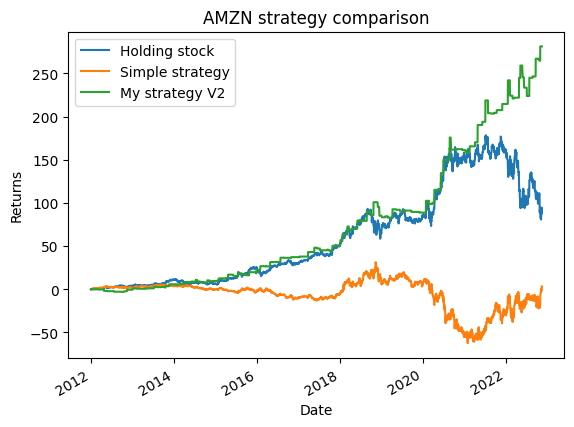

In [167]:
df.plot(y = ["return_holding_stock", "return_simple_strat", "return_bollinger_strat_V2"], 
        label = ["Holding stock", "Simple strategy", "My strategy V2"])
plt.ylabel("Returns")
plt.title("{} strategy comparison".format(ticker))